# Toy Models of Superposition - Code Companion

*By Keltin Grimes*

In this notebook we'll be recreating every result from Anthropic's [Toy Model of Superposition](https://transformer-circuits.pub/2022/toy_model/index.html) (TMS). The results are ordered the same as in TMS and follow the same notation, so can be compared directly, starting with the [Demonstrating Superposition](https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating) section.

All sections are set up to run independently of each other, so once the 'Setup' section is run, you may freely jump from section to section. Just run the relevant "Model Code" and/or "Plotting Code" subsections (collapsed by default in Colab).

The quality of results for some plots greatly depends on the number of training iterations or randomized trials. The training presets in this notebook are generally set for quality over speed (within reason), but you may adjust them according to your preference.

## Setup

Always run this section. Once ran, you can jump to any other section without issue. It might be useful to look through this section to understand how the models and training loops are set up.

#### Imports and Helper Functions

We define a base training function (`train_weighted`), and a function to repeatedly train and take the model with the lowest loss (`train_trials`). We also set the device (CPU or GPU) here.

In [ ]:
import matplotlib.colors as plt_colors
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import networkx as nx
import numpy as np
import torch
from torch import nn
import torch.nn.functional as f
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def train_weighted(net, iterations=1_000, batch_size=128, lr=0.01,
                   lr_scheduler="cosine", weight_decay=1e-2, verbose=True):
    """
    Trains the given network. Returns the losses from each instance at each iteration.
    Uses AdamW optimizer, ReduceLROnPlateau scheduler, and clips gradients for
    stability at very low losses.

    :param net: Model to train, of form `LinearModel` (see 'Demonstrating Superposition')
    :param iterations: Number of iterations to train
    :param batch_size: Batch size
    :param lr: Initial learning rate
    :param lr_scheduler: Either "cosine" or "constant"
    :param verbose: If true, prints progress bar over iterations
    :return: Tensor of shape (iterations, n_instances) containing the model losses
    """
    optimizer = optim.AdamW(net.parameters(), lr=lr, weight_decay=weight_decay)
    if lr_scheduler != "constant":
        scheduler = CosineAnnealingLR(optimizer, T_max=iterations)
    net.to(device)
    net.train()

    losses = []

    if verbose:
        pbar = tqdm(range(iterations))
    else:
        pbar = range(iterations)
    for i in pbar:
        x = net.get_batch(batch_size).to(device)

        optimizer.zero_grad()
        x_ = net(x)

        instance_losses = net.loss_fn(x, x_, net.I)
        loss = instance_losses.mean()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 2.0)
        optimizer.step()

        losses.append(instance_losses.detach().clone())

        if lr_scheduler != "constant":
            scheduler.step()

        if verbose and i % 50 == 0:
            pbar.set_description(f"Loss: {loss / batch_size / net.n_feat:.8f}")

    net.eval()
    net.to("cpu")

    return torch.stack(losses)

In [ ]:
def train_trials(net, trials, *args, test_batch_size=10_000, verbose=True, **kwargs):
    """
    Repeatedly trains the same network (with different seeds), and for each instance
    takes the trial with the lowest test loss.

    :param net: Model to train, of form `LinearModel` (see 'Demonstrating Superposition')
    :param trials: Number of randomized trials to run
    :param *args: Arguments passed directly to `train_weighted` after `net`
    :param test_batch_size: Batch size for calculating test loss
    :param verbose:
    :param **kwargs: Keyword arguments passed directly to `train_weighted`
    :return: Tensor of shape (n_instances,) containting the best test loss found for
        each instance. Net will be set with the best parameters found for each instance
    """
    # Store best losses/weights
    best_losses = torch.inf * torch.ones(net.n_instances)
    best_weights = net.get_weights()

    if verbose:
        pbar = tqdm(range(trials))
    else:
        pbar = range(trials)
    for trial in pbar:
        # Re-intialize model
        net.reset_weights()
        # Train model
        losses = train_weighted(net, *args, verbose=False, **kwargs)
        # Get losses
        x = net.get_batch(test_batch_size)
        _x = net(x)
        losses = net.loss_fn(x, _x, net.I)
        # Update best weights
        current_weights = net.get_weights()
        better_mask = losses < best_losses
        for name, weights in current_weights.items():
            # Expand mask to shape of parameters
            expanded_mask = better_mask.view(-1, *[1] * (weights.dim() - 1))
            best_weights[name] = torch.where(expanded_mask, weights.detach(), best_weights[name])
        # Update best losses
        best_losses = torch.where(losses < best_losses, losses.detach(), best_losses)

    # Save best weights to model
    net.set_weights(**best_weights)
    net.eval()

    return best_losses

In [ ]:
def remove_all_labels(ax):
    """Removes all axes labels and tick marks"""
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
        labelbottom=False, labelleft=False)

#### Common Plotting Functions

In [ ]:
# Create colormap for plotting model weights
colors = [(0, 0, 1), (0.95, 0.95, 0.95), (1, 0, 0)]  # Red, Light Gray, Blue
positions = [0, 0.5, 1]  # Corresponding positions for the colors
WEIGHT_CMAP = plt_colors.LinearSegmentedColormap.from_list(
    'custom_colormap', list(zip(positions, colors)), N=256)

def plot_matrix(W, figure=None, colorbar=False):
    """Plots a matrix as a heatplot"""
    if figure is None:
        figure = plt.subplots(1, 1, figsize=(5, 5))
    fig, ax = figure

    ax.imshow(W, vmin=-1, vmax=1, cmap=WEIGHT_CMAP)
    if colorbar:
        fig.colorbar(ax.get_images()[0], ax=ax)

In [ ]:
def get_norm_and_superposition(W):
    """For each feature calculate the norm and superposition/dimensionality sharing"""
    norm = torch.norm(W, p=2, dim=1)
    W_norm = W / norm.unsqueeze(1)

    dot_products = torch.einsum('ij,kj->ik', W_norm, W) # Calculate all dot products
    dot_products.fill_diagonal_(0)                      # Zero-out diagonal
    superposition = torch.sum(dot_products**2, dim=1)   # Sum of squares for each row

    return norm, superposition

In [ ]:
def dimensionality(W):
    """
    Feature dimensionality as defined here:
    https://transformer-circuits.pub/2022/toy_model/index.html#geometry-dimensionality
    """
    norms = torch.norm(W, dim=1)
    W_hat = W / torch.clamp(norms.unsqueeze(1), 1e-6, float('inf'))
    interference = torch.sum(torch.einsum('ih,jh->ij', W_hat, W)**2, dim=1)
    return norms**2 / interference

In [ ]:
def stacked_neuron_bar_plot(fig, ax, W, normalize=False, abs_weight=False, title=False, color_by="super", n_colors=None, bar_width=0.8):
    n_feat, n_neurons = W.shape

    # Determine the colors for each feature
    if color_by == "feature":
        colors = plt.cm.gist_rainbow(torch.linspace(0, 1, n_feat if not n_colors else n_colors+1))
    else:
        cmap = plt.get_cmap('viridis')


    # Rescale each neuron to have the largest-magnitude weight with magnitude 1
    if normalize:
        max_magnitude = torch.abs(W).max(dim=0, keepdim=True).values
        W = W / max_magnitude

    if color_by != "feature":
        norm, superposition = get_norm_and_superposition(W)
        superposition = torch.clamp(superposition, max=1)

    # Initialize the y position for each rectangle
    y_position_top = torch.zeros(n_neurons)
    y_position_bot = torch.zeros(n_neurons)

    for j in range(n_feat):
        weight = W[j, :] # (1, n_neurons)
        color = colors[j] if color_by == "feature" else cmap(superposition[j])
        height = weight
        if abs_weight:
            height = torch.abs(weight)

        y = (height >= 0) * y_position_top.clone() + (height < 0) * y_position_bot.clone()
        y_position_top += (height >= 0) * height
        y_position_bot += (height < 0) * height

        ax.bar(range(n_neurons), height, bottom=y, color=color, width=bar_width, align='center', edgecolor='black')

    # Add a horizontal black line at x=0
    ax.axhline(0, color='black', linestyle='--', linewidth=1)

    # Set the x-axis labels to represent neurons
    ax.set_xticks(torch.arange(n_neurons))
    ax.set_xticklabels(torch.arange(n_neurons).numpy())

    # Calculate the aspect ratio based on the figure dimensions and x-limits
    aspect_ratio = bar_width    # Want a box of unit height to be square
    x_range = ax.get_xlim()[1] - ax.get_xlim()[0]
    y_range = x_range * (ax.get_figure().get_figheight() / ax.get_figure().get_figwidth()) * aspect_ratio

    # Adjust the y-limits based on the aspect ratio
    if abs_weight:
        ax.set_ylim(0, y_range)
    else:
        ax.set_ylim(-y_range / 2, y_range / 2)

    # Set the aspect of the plot to 'equal' to ensure x and y are scaled the same
    ax.set_aspect(aspect_ratio, adjustable='datalim')

#### Initial Model Definitions

We define a class for the linear model ($h = W x$, $x' = W^T h + b$), which includes the reconstruction task and importance-weighted loss function used for most of the paper. All the variations in models and tasks will follow this template. The models train many independent instances at once to allow for analysis over ranges of feature sparsities or importances.

We then define the ReLU output model ($h = W x$, $x' = \operatorname{ReLU}(W^T h + b)$) by subclassing the linear model and redefining the `forward` method to include the ReLU.

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, n_feat, hidden_dim, n_instances, S, I):
        super(LinearModel, self).__init__()
        self.n_feat = n_feat
        self.hidden_dim = hidden_dim
        self.n_instances = n_instances

        # Store original S
        self.S = S
        # Expand to shape (n_instances, n_feat) if needed
        # - Allows for different features to have different sparsity
        if len(S.shape) == 1:
            self.S_exp = S.unsqueeze(1).expand(-1, n_feat)
        else:
            self.S_exp = S

        self.register_buffer("I", I)#self.I = I

        # Initialize parameter matrices
        self.reset_weights()

    def reset_weights(self):
        self.W = nn.Parameter(torch.zeros(self.n_instances, self.n_feat, self.hidden_dim))
        self.W = nn.init.xavier_normal_(self.W)
        self.b = nn.Parameter(torch.zeros(self.n_instances, self.n_feat))

    def forward(self, x):
        # x: (batch, n_instances, n_feat)
        h = torch.einsum('...if,...ifh->...ih', x, self.W)
        return torch.einsum('...ih,...ifh->...if', h, self.W) + self.b

    def get_weights(self):
        return {'W': self.W.detach().clone(), 'b': self.b.detach().clone()}

    def set_weights(self, W, b):
        self.W.data = W.data
        self.b.data = b.data

    def get_batch(self, batch_size):
        return (
            torch.bernoulli(torch.ones((batch_size, self.n_instances, self.n_feat)) - self.S_exp) *
            torch.rand((batch_size, self.n_instances, self.n_feat))
        )

    def loss_fn(self, inputs, outputs, I):
        # Returns one loss for each instances: (batch, n_instances, n_feat) -> (n_instances, )
        return torch.mean(I * torch.square(inputs - outputs), dim=(0, 2))

In [ ]:
class ReLUOutput(LinearModel):
    def forward(self, x):
        # x: (batch, n_instances, n_feat)
        h = torch.einsum('...if,...ifh->...ih', x, self.W)
        return f.relu(torch.einsum('...ih,...ifh->...if', h, self.W) + self.b)

## Demonstrating Superposition

#### Plotting Code

In [ ]:
def plot_superposition(W, figure=None):
    """Horizontal bar plot of norm of each feature, colored by superposition"""
    if figure is None:
        figure = plt.subplots(1, 1)
    fig, ax = figure

    norm, superposition = get_norm_and_superposition(W)
    superposition[superposition > 1] = 1
    norm[norm > 1] = 1

    cmap = plt.get_cmap('viridis')
    indices = torch.arange(W.shape[0]-1, -1, -1)
    ax.barh(indices, norm, color=cmap(superposition), height=0.6)

def plot_instance(net, figure=None, instance=0):
    """Plots, W, b, and superposition for a single instance"""
    if figure is None:
        figure = plt.subplots(1, 3, figsize=(8, 3))
    fig, axes = figure

    W = net.get_weights()['W'].detach()[instance]
    b = net.get_weights()['b'].detach()[instance]

    # Plot W
    plot_matrix(torch.einsum('ij,kj->ik', W, W), (fig, axes[0]))
    remove_all_labels(axes[0])
    axes[0].set_title('$W^TW$')
    # Plot b
    plot_matrix(b.unsqueeze(1), (fig, axes[1]))
    remove_all_labels(axes[1])
    axes[1].set_title('$b$')
    # Plot superposition
    plot_superposition(W, (fig, axes[2]))
    remove_all_labels(axes[2])
    axes[2].set_title('$||W_i||$')

def plot_W_and_superposition(net, figure=None, titles=None):
    """Plots a row of weight matrices and a row of superposition plots"""
    if figure is None:
        figure = plt.subplots(2, net.n_instances, figsize=(12, 4))
    fig, axes = figure

    W = net.get_weights()['W'].detach()
    for i in range(net.n_instances):
        # W W^T plot
        plot_matrix(torch.einsum('ij,kj->ik', W[i], W[i]), (fig, axes[0, i]))
        remove_all_labels(axes[0, i])

        # Superposition plot
        plot_superposition(W[i], (fig, axes[1, i]))
        remove_all_labels(axes[1, i])

        if titles:
            axes[0,i].title.set_text(titles[i])

#### Results

The first experiment simply shows the behavior of the linear model exhibiting no superposition.

Models are defined by config dictionaries.
- Models have a fixed size, but train `n_instances` independent copies at once, allowing for sweeping over other parameters.
- `n_feat` is the number of input features and `hidden_dim` is the number of hidden dimensions; these are fixed across all instances.
- `S` is the sparsity of the input features, and there should be a value for each instance (i.e `S` should be shape `(n_instances,)`.
- `I` is the importance of each feature, so `I` should be shape `(n_feat,)`. In some cases we allow `I` to be shape `(n_instances, n_feat)`, to allow for instance-level control of feature importances.

`n_feat`, `hidden_dim`, `S`, and `I` correspond to $n$, $m$, $S$, and $I_i$ in TMS, respectively.

Here we have $n=20$, $m=5$, and $I_i = 0.7^i$. We only have one instance, and it has a sparsity of $0.9$.

In [ ]:
config = {
    'n_feat': 20,
    'hidden_dim': 5,
    'S': torch.tensor([0.9])
}
config['n_instances'] = len(config['S'])
config['I'] = torch.pow(0.7, torch.arange(config['n_feat']))
net = LinearModel(**config)

losses = train_weighted(net, iterations=1_000)

Loss: 0.00000032: 100%|██████████| 1000/1000 [00:07<00:00, 127.14it/s]


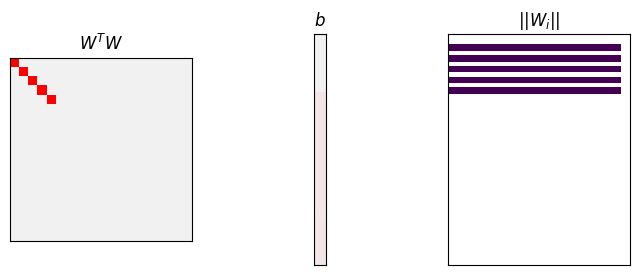

In [ ]:
plot_instance(net)

Here we run the same experiment, but for the ReLU output model with sparsity ranging from $0$ to $0.999$. Note that we do not plot the bias term.

In [ ]:
config = {
    'n_feat': 20,
    'hidden_dim': 5,
    'S': torch.tensor([0, 0.7, 0.9, 0.97, 0.99, 0.997, 0.999])
}
config['n_instances'] = len(config['S'])
config['I'] = torch.pow(0.7, torch.arange(config['n_feat']))
net = ReLUOutput(**config)

losses = train_weighted(net, iterations=2_000)

Loss: 0.00000025: 100%|██████████| 2000/2000 [00:24<00:00, 83.29it/s] 


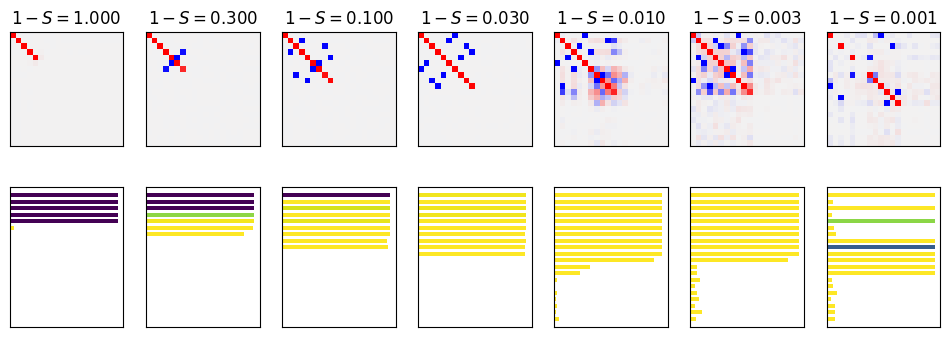

In [ ]:
plot_W_and_superposition(net, titles=[f"$1-S={1-S:.3f}$" for S in config['S']])

And then for a larger version.

In [ ]:
config = {
    'n_feat': 80,
    'hidden_dim': 20,
    'S': torch.tensor([0, 0.7, 0.9, 0.97, 0.99, 0.997, 0.999])
}
config['n_instances'] = len(config['S'])
config['I'] = torch.pow(0.9, torch.arange(config['n_feat']))
net = ReLUOutput(**config)

losses = train_weighted(net, iterations=2_000)

Loss: 0.00000004: 100%|██████████| 2000/2000 [00:23<00:00, 84.45it/s] 


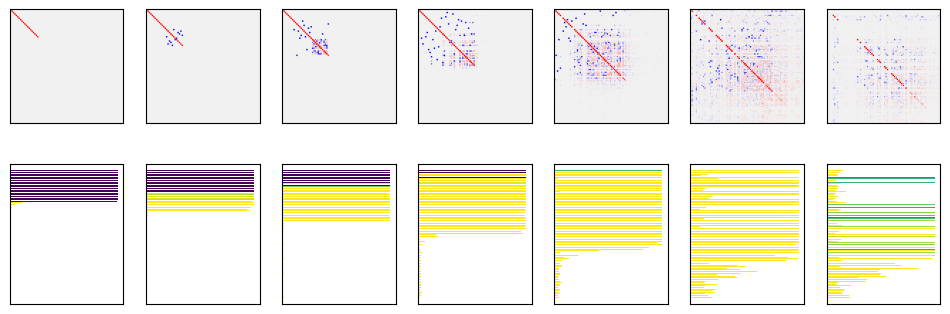

In [ ]:
plot_W_and_superposition(net)

## Superposition as a Phase Change

These plots can be difficult to replicate exactly (especially the latter plot), so therefore take a long time to generate. You may want to decrease the number of training iterations and/or trials for initial explorations.

We only plot the emperical results here; information on replicating the analytical solutions can be found in [this notebook](https://github.com/wattenberg/superposition/blob/main/Exploring_Exact_Toy_Models.ipynb) by Martin Wattneberg (an original TMS co-author).

#### Plotting Code

In [ ]:
def plot_phase_change(net, relative_importances, S, grid_size, num_ticks=3):
    # Calculate norm and superposition for each instance
    net_data = [get_norm_and_superposition(W) for W in net.W.detach().clone()]
    # Filter to just the last feature
    extra_feature_norm = [norm[-1] for norm, _ in net_data]
    extra_feature_super = [super[-1] for _, super in net_data]
    # Convert to tensor
    extra_feature_norm = torch.stack(extra_feature_norm).reshape((grid_size, grid_size))
    extra_feature_super = torch.stack(extra_feature_super).reshape((grid_size, grid_size))

    # Left to right is increasing superposition, bottom to top is increasing norm
    bottom_left, bottom_right = torch.tensor([1., 1., 1.]), torch.tensor([1., 1., 1.])
    top_left, top_right = torch.tensor([0., 0., 1.]), torch.tensor([1., 0., 0.])

    # Create 2-D colormap
    x, y = extra_feature_norm.unsqueeze(-1), extra_feature_super.unsqueeze(-1)
    x, y = x.clamp(max=1), y.clamp(max=1)
    colors = (
        (1 - x) * ((1 - y) * bottom_left + y * bottom_right) +
        x * ((1 - y) * top_left + y * top_right)
    )

    # Plot setup
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(colors.permute(1, 0, 2), origin='lower', extent=[0, 1, 0, 1])

    # Set tick labels
    density = 1 - S
    tick_positions = np.linspace(0, 1, num_ticks)
    tick_labels_importances = np.logspace(torch.log10(relative_importances.min()),
                                          torch.log10(relative_importances.max()), num_ticks)
    tick_labels_S = np.logspace(torch.log10(density.min()), torch.log10(density.max()), num_ticks)

    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    ax.set_xticklabels([f"{val:.2f}" for val in tick_labels_importances], rotation=0)
    ax.set_yticklabels([f"{val:.2f}" for val in tick_labels_S])

    ax.set_xlabel("Relative Feature Importance")
    ax.set_ylabel("Feature Density ($1-S$)")

    plt.show()

#### Results

With two features and one hidden dimension, we vary both the relative importance of the second feature and the overall feature sparsity. Note here we use the trick of expanding $I$ to be shape `(n_instances, n_feat)` to vary the importance of the second feature.

You can adjust the grid size to increase or decrease the resolution of the plot.

In [ ]:
grid_size = 20
config = {
    'n_feat': 2,
    'hidden_dim': 1,
    'n_instances': grid_size**2
}
S = 1 - torch.logspace(-2, 0, grid_size)
config['S'] = S.repeat(grid_size)   # Repeat for grid
config['I'] = torch.ones((config['n_instances'], config['n_feat']))
# Vary importance of last feature
relative_importances = torch.logspace(-1, 1, grid_size)
config['I'][:,-1] = relative_importances.repeat_interleave(grid_size)   # Repeat for grid
net = ReLUOutput(**config)

trials = 10
best_losses = train_trials(net, trials, iterations=2_000)

100%|██████████| 10/10 [04:05<00:00, 24.56s/it]


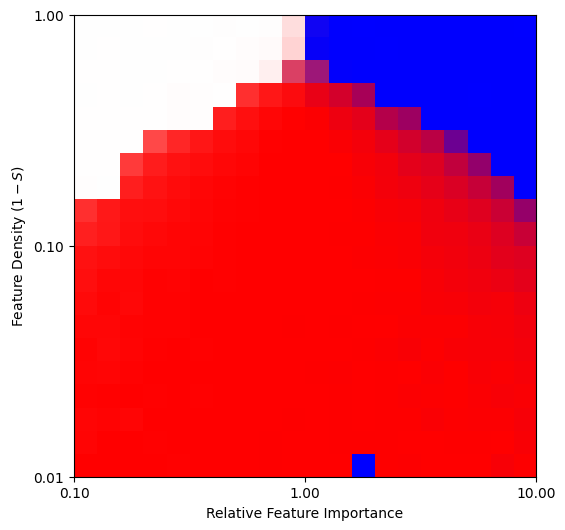

In [ ]:
plot_phase_change(net, relative_importances, S, grid_size)

Now with three features and two hidden dimension, we again vary both the relative importance of the last (third) feature and the overall feature sparsity.

Note: this plot is especially difficult to replicate.

In [ ]:
grid_size = 20
config = {
        'n_feat': 3,
        'hidden_dim': 2,
        'n_instances': grid_size**2
    }
S = 1 - torch.logspace(-2, 0, grid_size)
config['S'] = S.repeat(grid_size)   # Repeat for grid
config['I'] = torch.ones((config['n_instances'], config['n_feat']))
# Vary importance of last feature
relative_importances = torch.logspace(-1, 1, grid_size)
config['I'][:,-1] = relative_importances.repeat_interleave(grid_size)   # Repeat for grid
net = ReLUOutput(**config)

trials = 20
best_losses = train_trials(net, trials, iterations=2_000)

100%|██████████| 20/20 [25:57<00:00, 77.88s/it]


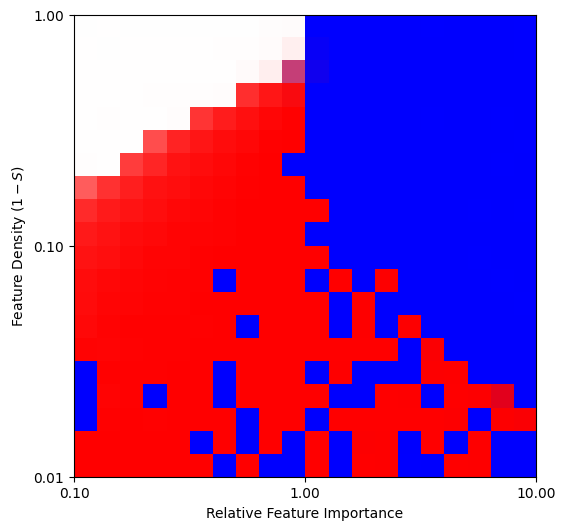

In [ ]:
plot_phase_change(net, relative_importances, S, grid_size)

## The Geometry of Superposition

### Uniform Superposition

#### Plotting Code

In [ ]:
def plot_dimensions_per_feature(net, figure=None, plot_dimensionality=False):
    if figure is None:
        figure = plt.subplots(1, 1, figsize=(10, 5))
    fig, ax = figure

    # W = net.W.detach()
    W = net.get_weights()['W'].detach()

    f_norms = []
    odds_sparsity = []
    for i in range(len(net.S)):
        f_norms.append(net.hidden_dim / torch.norm(W[i], p='fro')**2)
        odds_sparsity.append(1/(1-net.S[i]))

        if plot_dimensionality:
            jitter = 0.02
            ax.scatter(
                1/(1-net.S[i])+np.random.uniform(-jitter, jitter, net.n_feat), dimensionality(W[i]),
                s=0.1, color='black', zorder=2
            )

    ax.plot(odds_sparsity, f_norms, color='grey', zorder=1)

    # Plot some sticky points
    plt.axhline(y=1.0, color='grey', linestyle='--', alpha=0.5)
    plt.axhline(y=0.5, color='grey', linestyle='--', alpha=0.5)

    # Pretty-fy plot
    plt.xscale("log")
    plt.xlim([1-0.05,10+1])
    plt.ylim([0,1.1])
    ax.xaxis.set_major_formatter(FormatStrFormatter("%i"))
    ax.xaxis.set_minor_formatter(FormatStrFormatter("%i"))
    plt.xlabel("Hidden Dimensions per Feature")
    plt.ylabel("$1 / (1-S)$ (log scale)")

In [ ]:
def plot_feature_graph(W, min_dimensionality, pressure_factor=1):
    # Filter by min_dimensionality
    W = W.clone()[dimensionality(W) > min_dimensionality, :]
    n_feat = W.shape[0]
    assert n_feat > 0

    # Compute absolute value of all dot product combinations
    dot_prod_matrix = np.abs(np.dot(W, W.T))

    # Create graph
    plt.figure(figsize=(10,6))
    G = nx.Graph()

    # Add node for each feature
    for i in range(n_feat):
        G.add_node(i)

    # Add edges with weights based on dot products
    for i in range(n_feat):
        for j in range(i + 1, n_feat):
            G.add_edge(i, j, weight=dot_prod_matrix[i, j])

    # Draw the graph
    pos = nx.spring_layout(G, k=1/(pressure_factor * np.sqrt(n_feat)))

    # Add edges
    weights = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edges(G, pos, edge_color='black', width=[v * 0.5 for v in weights.values()])

    # Add nodes
    nx.draw_networkx_nodes(G, pos, node_size=100)

    plt.axis('off')

#### Results

We plot the average dimensions per feature, first without and then with the individual feature dimensionalities, for various feature sparsities.

In [ ]:
config = {
    'n_feat': 400,
    'hidden_dim': 30,
    'n_instances': 50
}
config['S'] = 1 - 1 / torch.linspace(1, 10, config['n_instances'])
config['I'] = torch.ones(config['n_feat'])

net = ReLUOutput(**config)

losses = train_weighted(net, iterations=10_000, lr=1e-3, lr_scheduler="constant")

Loss: 0.00000103: 100%|██████████| 10000/10000 [05:34<00:00, 29.91it/s]


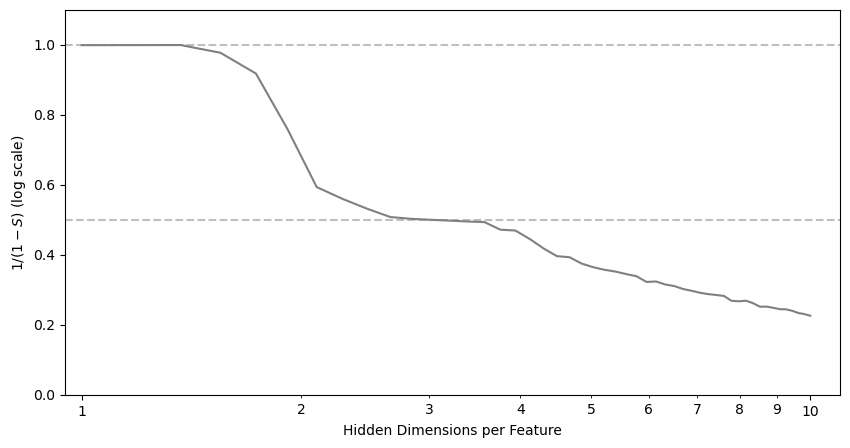

In [ ]:
plot_dimensions_per_feature(net)

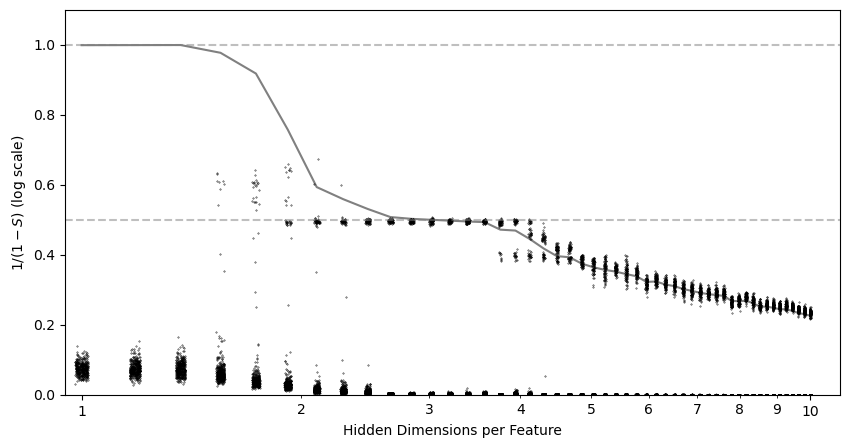

In [ ]:
plot_dimensions_per_feature(net, plot_dimensionality=True)

This next cell lets you visualize the weight geometry for a model. Select an instance with `instance_idx` and filter to a minimum dimensionality with `min_dimensionality`. Instance IDs go from left to right on the above plot. You should set `min_dimensionality` high enough such that it at least filters out the features that are not represented by the model, otherwise the graph will be a mess. You can also increase `pressure_factor` to try to push clusters away from each other if nodes are crowded.

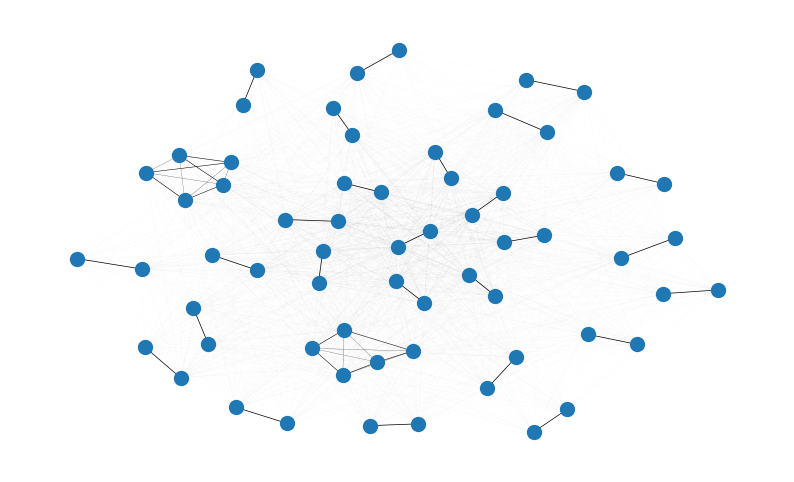

In [ ]:
instance_idx = 15
min_dimensionality = 0.2

plot_feature_graph(net.W.detach()[instance_idx], min_dimensionality)

### Non-Uniform Superposition

#### Plotting Code

In [ ]:
def canonicalize(W, feature_index=0):
    """
    Rotate the feature embeddings such that the feature_index'th is aligned vertically.
    """
    # Calculate the angle of the first feature vector with the positive y-axis
    angle = torch.atan2(W[feature_index, 1], W[feature_index, 0])  # atan2(y, x)
    # Determine if we need to rotate clockwise or counter-clockwise
    if W[feature_index, 1] < 0:
        rotation_angle = angle
    else:
        rotation_angle = np.pi - angle
    rotation_angle = angle - torch.tensor(np.pi/2)

    # Define the rotation matrix to rotate by the calculated angle
    rotation_matrix = torch.tensor([
        [torch.cos(rotation_angle), -torch.sin(rotation_angle)],
        [torch.sin(rotation_angle), torch.cos(rotation_angle)]
    ], dtype=torch.float32)

    # Apply the rotation to all weight vectors
    W_rotated = torch.matmul(W, rotation_matrix)
    return W_rotated

In [ ]:
def convert_rectangular(phis, rhos):
    return rhos*np.cos(phis), rhos*np.sin(phis)

def plot_features_2D(Ws, relative_density, figure=None, colorbar=True):
    if figure is None:
        figure = plt.subplots(1, 1)
    fig, ax = figure

    viridis = plt.get_cmap('viridis')

    # Canonicalize each weight matrix and plot points
    for i in range(len(Ws)):
        W = Ws[i]
        if torch.norm(W[0]) > 0.5:
            W_rotated = canonicalize(W)
        else:
            W_rotated = canonicalize(W, feature_index=1)
        color = viridis(relative_density[i].item())
        for j in range(W.shape[0]):
            ax.scatter([0, W_rotated[j, 0]], [0, W_rotated[j, 1]], color=color, s=7.5)

    # Create colorbar
    if colorbar:
        norm = plt_colors.LogNorm(vmin=relative_density.min().item(),
                                vmax=relative_density.max().item())
        sm = plt.cm.ScalarMappable(cmap=viridis, norm=norm)
        cbar = plt.colorbar(sm, ticks=[relative_density.min().item(), 1, relative_density.max().item()],
                            format='%.2f', ax=ax)
        cbar.set_label('Relative Feature Density')

    # Plot circle of radius 1
    thetas, rs = np.linspace(0, 2 * np.pi, 1000), np.ones(1000)
    x, y = rs*np.cos(thetas), rs*np.sin(thetas)
    rc = ax.plot(x, y, color='black', linewidth=0.5)

    ax.set_aspect('equal', adjustable='box')
    remove_all_labels(ax)

In [ ]:
def train_trials_and_plot_loss(net, trials, relative_density, figure=None, **kwargs):
    if figure is None:
        figure = plt.subplots(1, 1, figsize=(10, 5))
    fig, ax = figure

    for t in range(trials):
        # Re-initialize weights
        net.reset_weights()

        # Use train_trials so we get the test loss
        best_losses = train_trials(net, trials=1, verbose=False, **kwargs)

        colors = []
        for i in range(len(best_losses)):
            # Get feature norms
            norms = torch.norm(net.W[i].detach(), p=2, dim=1)
            # Consider a feature represented if it's norm is above 0.5
            if sum(norms > 0.5) <= 3:   # Triangle
                colors.append('green')
            elif sum(norms > 0.5) <= 4: # Square
                colors.append('yellow')
            else:                       # Pentagon
                colors.append('orange')

        ax.scatter(relative_density, best_losses, color=colors, s=15)

    ax.set_xscale("log")
    ax.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax.set_xlabel("Relative Feature Density")
    ax.set_ylabel("Loss")

#### Results

Note that the cutoff between square and pentagon solutions may not be captured exactly (especially if the training iterations are low), so you may see some square solutions in the subplot meant for pentagons. Also note that with the current settings, all points in the the square (left) subplot have relative density below the range of the colorbar.

In [ ]:
config = {
    'n_feat': 5,
    'hidden_dim': 2,
    'n_instances': 41
}
S = 0.95 * torch.ones((config['n_instances'], config['n_feat']))
relative_density = torch.logspace(-3, 1, config['n_instances'])
S[:, 0] = 1 - 0.05 * relative_density
config['S'] = S
config['I'] = torch.ones(config['n_feat'])

net = ReLUOutput(**config)

trials = 4
best_losses = train_trials(net, trials, iterations=2_000)

100%|██████████| 4/4 [00:31<00:00,  7.98s/it]


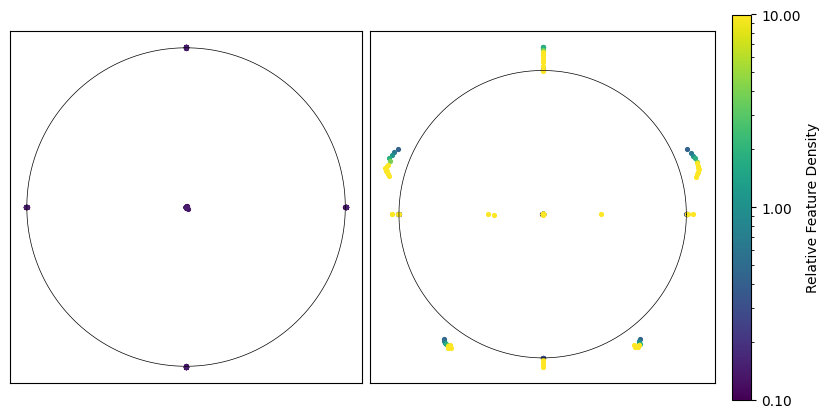

In [ ]:
square_pentagon_cutoff = config['n_instances'] // 2

fig, axes = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1, 1]})
Ws = net.get_weights()['W'].detach()

# Square solutions
plot_features_2D(Ws[:square_pentagon_cutoff], relative_density, figure=(fig, axes[0]), colorbar=False)
# Pentagon solutions
plot_features_2D(Ws[square_pentagon_cutoff:], relative_density[square_pentagon_cutoff:], figure=(fig, axes[1]))

# Manually adjusting the axes so they are the same size
position = axes[0].get_position()
axes[1].set_position([position.x0+position.width, position.y0, position.width, position.height])

We train many models with (mostly) the same config as above, plotting the relative density versus the loss, with points colored by their geometry. As in the TMS plot, triangles are green, squares are yellow, and pentagons are orange. Here training for fewer iterations may produce better results, otherwise most trials will converge at the optimal geometry.

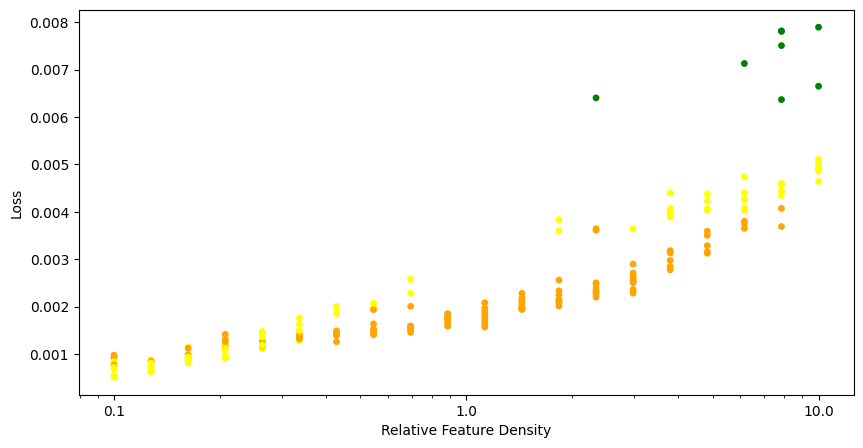

In [ ]:
config = {
    'n_feat': 5,
    'hidden_dim': 2,
    'n_instances': 20
}
S = 0.95 * torch.ones((config['n_instances'], config['n_feat']))
relative_density = torch.logspace(-1, 1, config['n_instances'])
S[:, 0] = 1 - 0.05 * relative_density
config['S'] = S
config['I'] = torch.ones(config['n_feat'])

net = ReLUOutput(**config)

trials = 10
train_trials_and_plot_loss(net, trials, relative_density, iterations=1_000)

### Correlated and Anticorrelated Features

#### Model Code

We define models `ReLUOutputCorrelated` and `ReLUOutputAntiCorrelated` where input features are correlated and anti-correlated, respectively, as in TMS.

In [ ]:
class ReLUOutputCorrelated(ReLUOutput):
    def __init__(self, n_feat_sets, features_per_set, hidden_dim, n_instances, S, I):
        self.n_feat_sets = n_feat_sets
        self.features_per_set = features_per_set
        super().__init__(n_feat_sets * features_per_set, hidden_dim, n_instances, S, I)

    def get_batch(self, batch_size, p=1.0):
        # Initialize the batch. Features are grouped in order (e.g. 0,0,1,1,...)
        batch = torch.zeros(batch_size, self.n_instances, self.n_feat_sets * self.features_per_set)

        # Iterate over each feature set
        for i in range(self.n_feat_sets):
            # Determine if the current set should be zero or not for each instance
            set_non_zero = torch.bernoulli(torch.ones((batch_size, self.n_instances, 1)) - self.S.unsqueeze(0).unsqueeze(-1))

            # Determine if each feature within the set should be 'on' based on probability p
            features_on = torch.bernoulli(p * torch.ones((batch_size, self.n_instances, self.features_per_set)))

            # Get final features
            features = set_non_zero * features_on * torch.rand((batch_size, self.n_instances, self.features_per_set))

            # Place the features in the appropriate part of the batch
            start_idx = i * self.features_per_set
            end_idx = start_idx + self.features_per_set
            batch[:, :, start_idx:end_idx] = features

        return batch

In [ ]:
class ReLUOutputAntiCorrelated(ReLUOutput):
    def __init__(self, n_feat_sets, features_per_set, hidden_dim, n_instances, S, I):
        self.n_feat_sets = n_feat_sets
        self.features_per_set = features_per_set
        super().__init__(n_feat_sets * features_per_set, hidden_dim, n_instances, S, I)

    def get_batch(self, batch_size, p=1.0):
        # Initialize the batch. Features are grouped in order (e.g. 0,0,1,1,...)
        batch = torch.zeros(batch_size, self.n_instances, self.n_feat_sets * self.features_per_set)

        # Iterate over each feature set
        for i in range(self.n_feat_sets):
            # Determine if the current set should be zero or not for each instance
            set_non_zero = torch.bernoulli(torch.ones((batch_size, self.n_instances, 1)) - self.S.unsqueeze(0).unsqueeze(-1))

            # Sample an index for the active feature
            active_feature_indices = torch.randint(0, self.features_per_set, (batch_size, self.n_instances, 1))

            # Use scatter_ to selectively activate one feature per set
            active_features = torch.zeros((batch_size, self.n_instances, self.features_per_set))
            active_features.scatter_(-1, active_feature_indices, 1)

            # Zero-out sets that are off
            active_features *= set_non_zero

            # Place the generated features in the appropriate part of the batch
            start_idx = i * self.features_per_set
            end_idx = start_idx + self.features_per_set
            batch[:, :, start_idx:end_idx] = active_features

        return batch

#### Plotting Code

In [ ]:
def plot_grouped_features(W, n_feat_sets, features_per_set, ax):
    assert(W.shape[1] == 2)
    colors = ['red', 'blue', 'green']
    for i in range(W.shape[0]):
        ax.plot([0, W[i, 0]], [0, W[i, 1]], color=colors[i // 2])
        ax.scatter([W[i, 0]], [W[i, 1]], color=colors[i // 2])

    ax.set_xlim([-1.2,1.2])
    ax.set_ylim([-1.2,1.2])
    ax.set_aspect('equal', adjustable='box')

def plot_grouped_features_row(Ws, n_feat_sets, features_per_set, figure=None, scale=2, titles=None):
    if figure is None:
        figure = plt.subplots(1, len(Ws), figsize=(8*scale, 4*scale))
    fig, axes = figure

    for i in range(len(Ws)):
        plot_grouped_features(Ws[i], n_feat_sets, features_per_set, axes[i])
        remove_all_labels(axes[i])

        if titles:
            axes[i].title.set_text(titles[i])

def plot_circle(r, figure=None):
    if figure is None:
        figure = plt.subplots(1, 1)
    fig, ax = figure

    # Plot circle of radius r
    thetas, rs = np.linspace(0, 2 * np.pi, 1000), r * np.ones(1000)
    x, y = rs*np.cos(thetas), rs*np.sin(thetas)
    rc = ax.plot(x, y, color='black', linewidth=0.5)

def plot_circle_row(r, n, figure=None):
    if figure is None:
        figure = plt.subplots(1, n, figsize=(8, 4))
    fig, axes = figure

    for i in range(n):
        plot_circle(r, figure=(fig, axes[i]))

#### Results

Here we plot two sets of two correlated features. Note that for this and following plots we do *not* rotate and flip the results into consistent orientations as they do in TMS.

In [ ]:
config = {
    'n_feat_sets': 2,
    'features_per_set': 2,
    'hidden_dim': 2,
    'n_instances': 6
}
config['S'] = 0.95 * torch.ones(config['n_instances'])
config['I'] = torch.ones((config['n_feat_sets'] * config['features_per_set']))

net = ReLUOutputCorrelated(**config)

losses = train_weighted(net, iterations=2_000)

Loss: 0.00000073: 100%|██████████| 2000/2000 [00:26<00:00, 74.77it/s] 


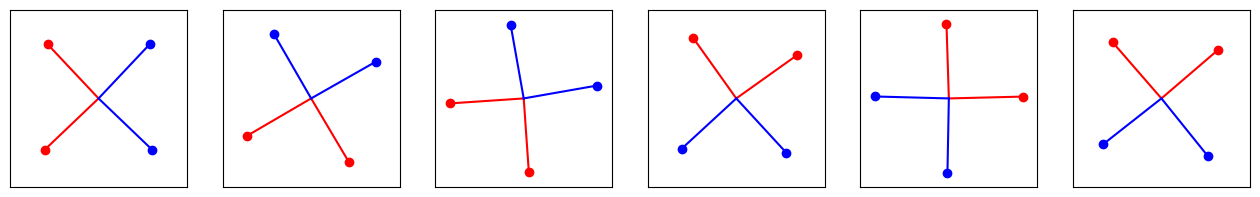

In [ ]:
plot_grouped_features_row(net.W.detach(), config['n_feat_sets'], config['features_per_set'])

Two sets of two anti-correlated features.

In [ ]:
config = {
    'n_feat_sets': 2,
    'features_per_set': 2,
    'hidden_dim': 2,
    'n_instances': 7
}
config['S'] = 0.95 * torch.ones(config['n_instances'])
config['I'] = torch.ones((config['n_feat_sets'] * config['features_per_set']))

net = ReLUOutputAntiCorrelated(**config)

best_losses = train_trials(net, trials=3, iterations=2_000)

100%|██████████| 3/3 [00:22<00:00,  7.66s/it]


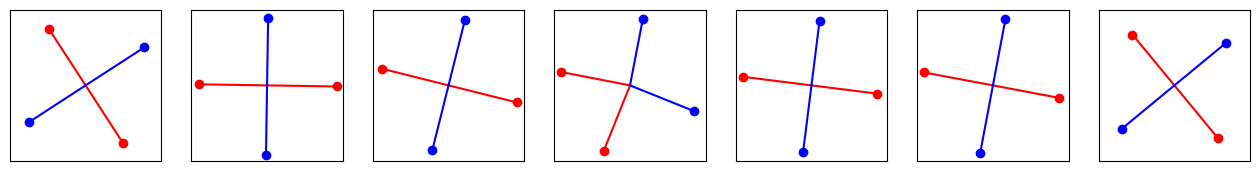

In [ ]:
plot_grouped_features_row(net.W.detach(), config['n_feat_sets'], config['features_per_set'])

Three sets of two correlated features

In [ ]:
config = {
    'n_feat_sets': 3,
    'features_per_set': 2,
    'hidden_dim': 2,
    'n_instances': 6
}
config['S'] = 0.95 * torch.ones(config['n_instances'])
config['I'] = torch.ones((config['n_feat_sets'] * config['features_per_set']))

net = ReLUOutputCorrelated(**config)

best_losses = train_trials(net, trials=3, iterations=2_000)

100%|██████████| 3/3 [00:16<00:00,  5.34s/it]


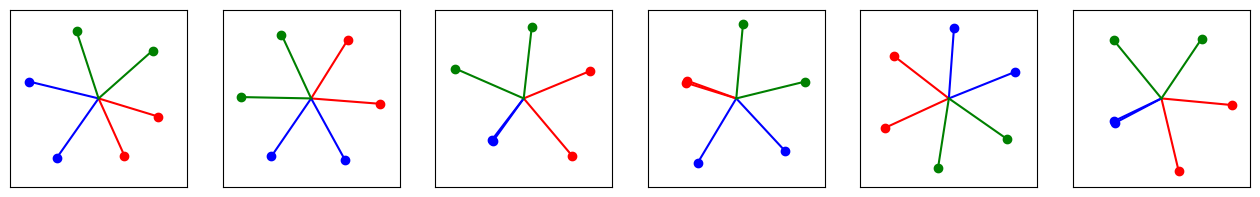

In [ ]:
plot_grouped_features_row(net.W.detach(), config['n_feat_sets'], config['features_per_set'])

Two sets of ten correlated features.

In [ ]:
config = {
    'n_feat_sets': 2,
    'features_per_set': 10,
    'hidden_dim': 10,
    'n_instances': 1
}
config['S'] = torch.tensor([0.99])
config['I'] = torch.ones((config['n_feat_sets'] * config['features_per_set']))

net = ReLUOutputCorrelated(**config)

losses = train_weighted(net, iterations=2_000)

Loss: 0.00000000: 100%|██████████| 2000/2000 [00:14<00:00, 141.64it/s]


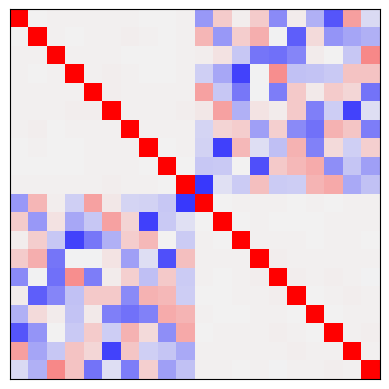

In [ ]:
fig, ax = plt.subplots()
W = net.W[0].detach()
plot_matrix(torch.einsum('ij,kj->ik', W, W), (fig, ax))
remove_all_labels(ax)

And finally, three sets of two correlated features, with varying feature sparsities.

In [ ]:
config = {
    'n_feat_sets': 3,
    'features_per_set': 2,
    'hidden_dim': 2,
    'n_instances': 5
}
config['S'] = torch.tensor([0.25, 0.75, 0.85, 0.9, 0.99])
config['I'] = torch.ones((config['n_feat_sets'] * config['features_per_set']))

net = ReLUOutputCorrelated(**config)

best_losses = train_weighted(net, iterations=7_500)

Loss: 0.00002290: 100%|██████████| 7500/7500 [00:57<00:00, 129.93it/s]


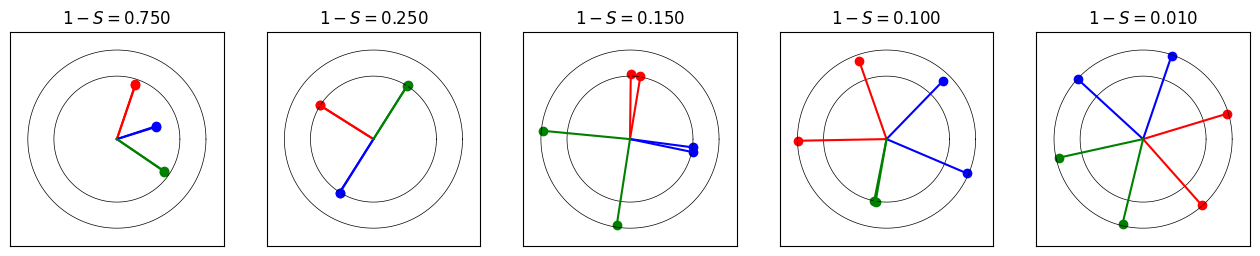

In [ ]:
figure = plt.subplots(1, len(net.W), figsize=(16, 8))
# Plot circles with radius 1/√2 and 1
plot_circle_row(r=1/(2**0.5), n=len(net.W), figure=figure)
plot_circle_row(r=1, n=len(net.W), figure=figure)
# Plot the features
plot_grouped_features_row(net.W.detach(), config['n_feat_sets'], config['features_per_set'],
                          figure=figure, titles=[f"$1-S={1-S:.3f}$" for S in config['S']])

## Superposition and Learning Dynamics

#### Model Code

We define a new training function that saves model weights and test losses at specified checkpoints so we can see how the model evolves over the course of training.

Note: if running this section on its own (specifically, without running the 'Correlated and Anticorrelated Features' section), it will also define the correlated features model for use in the second plot.

In [ ]:
def train_with_checkpoints(net, save_iterations, test_batch_size=10_000, verbose=True, **kwargs):
    """
    Trains a model, storing model weights at each iteration in save_iterations
    TODO: adjust training iterations based on save_iterations
    """
    weights = []
    losses = []

    pbar = range(max(save_iterations) + 1)
    if verbose:
        pbar = tqdm(pbar)
    for i in pbar:
        _ = train_weighted(net, iterations=1, verbose=False, **kwargs)

        if i in save_iterations:
            x = net.get_batch(test_batch_size)
            loss = net.loss_fn(x, net(x), net.I)
            losses.append(loss.detach())

            weights.append(net.get_weights())

    return weights, losses

In [ ]:
# Ensure ReLUOutputCorrelated is defined for this section.
# NOTE: We do this so that both `ReLUOutputCorrelated` and `ReLUOutputAntiCorrelated`
# are defined in the 'Correlated and Anticorrelated Features' section, which I
# believe improves readability, as opposed to defining them in the very beginning
# in the 'Setup' section. As a result, if running this section on its own, this
# needs to be done to ensure the class is defined. It is a tradeoff between
# readability and style; you may disagree with this decision.
try:
    ReLUOutputCorrelated
except NameError:
    class ReLUOutputCorrelated(ReLUOutput):
        def __init__(self, n_feat_sets, features_per_set, hidden_dim, n_instances, S, I):
            self.n_feat_sets = n_feat_sets
            self.features_per_set = features_per_set
            super().__init__(n_feat_sets * features_per_set, hidden_dim, n_instances, S, I)

        def get_batch(self, batch_size, p=1.0):
            # Initialize the batch. Features are grouped in order (e.g. 0,0,1,1,...)
            batch = torch.zeros(batch_size, self.n_instances, self.n_feat_sets * self.features_per_set)

            # Iterate over each feature set
            for i in range(self.n_feat_sets):
                # Determine if the current set should be zero or not for each instance
                set_non_zero = torch.bernoulli(torch.ones((batch_size, self.n_instances, 1)) - self.S.unsqueeze(0).unsqueeze(-1))

                # Determine if each feature within the set should be 'on' based on probability p
                features_on = torch.bernoulli(p * torch.ones((batch_size, self.n_instances, self.features_per_set)))

                # Get final features
                features = set_non_zero * features_on * torch.rand((batch_size, self.n_instances, self.features_per_set))

                # Place the features in the appropriate part of the batch
                start_idx = i * self.features_per_set
                end_idx = start_idx + self.features_per_set
                batch[:, :, start_idx:end_idx] = features

            return batch

#### Plotting Code

In [ ]:
def plot_dimensionality_over_time(dimensionalities, losses, test_iterations, figure=None):
    if figure is None:
        figure = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [2, 1]})
    fig, axes = figure

    # Plot dimensionalities
    for i in range(dimensionalities.shape[1]):
        axes[0].plot(test_iterations, dimensionalities[:,i], alpha=0.5)
    axes[0].set_xscale("log")
    axes[0].set_ylabel("Feature Dimensionality")

    # Plot losses
    axes[1].plot(test_iterations, losses)
    axes[1].set_xscale("log")
    axes[1].set_ylim(top=losses.min() + 0.005)
    axes[1].set_ylabel("Loss")

In [ ]:
def plot_3D_geometry(weights, test_iterations, iteration_limits, figure=None):
    if figure is None:
        fig = plt.figure(figsize=(12, 6))
        gs = gridspec.GridSpec(2, len(iteration_limits))
    else:
        fig, gs = figure

    # Setup axes for 3D plots
    axes_3D = [fig.add_subplot(gs[0, i], projection='3d') for i in range(len(iteration_limits))]
    # Setup axis for loss plot
    ax_loss = fig.add_subplot(gs[1, :])

    # Features are shaded according to their correlation group
    colors = ['lightgreen', 'green', 'darkgreen', 'lightblue', 'blue', 'darkblue']
    assert len(colors) == weights.shape[1]

    for i, ax in enumerate(axes_3D):
        # Plot each weight over time
        for j in range(weights.shape[1]):
            # Filter to a max iteration
            ax.plot3D(weights[:iteration_limits[i], j, 0],
                    weights[:iteration_limits[i], j, 1],
                    weights[:iteration_limits[i], j, 2], color=colors[j])
            ax.set_xlim([-1, 1])
            ax.set_ylim([-1, 1])
            ax.set_zlim([-1, 1])

        remove_all_labels(ax)

    # Plot losses with vertical lines corresponding to the 3D plots
    ax_loss.plot(test_iterations, losses, color="black")
    [ax_loss.axvline(test_iterations[x-1], color="black", linestyle="--") for x in iteration_limits]
    ax_loss.set_xscale("log")
    ax_loss.set_yscale("log")
    ax_loss.set_ylabel("Loss")

#### Results

We plot model losses and individual feature dimensionalities over the course of training. You may or may not see the "discrete energy level jumps" found in TMS, depending on the run. The plot in the paper seems to be a particularily good example.

In [ ]:
config = {
    'n_feat': 100,
    'hidden_dim': 10,
    'n_instances': 1
}
config['S'] = torch.tensor([0.55])
config['I'] = torch.ones(config['n_feat'])
net = ReLUOutput(**config)

# Reducing intialization scale to get cleaner plots
net.W = nn.Parameter(net.W.detach().clone() * 0.1)

# Store weight+loss at 100 points between iterations 100 to 100,000 (log-scale spacing)
start_exp, end_exp = 2, 5
n_iters = 100
test_iters = (torch.logspace(start_exp, end_exp, n_iters).int() - 1).unique()

# Train the model and save the feature dimensionalities and losses
weights, losses = train_with_checkpoints(net, test_iters, test_batch_size=10_000, lr=0.001)
dimensionalities = torch.stack([dimensionality(weight['W'][0]) for weight in weights])
losses = torch.tensor([loss[0].item() for loss in losses])

100%|██████████| 100000/100000 [05:24<00:00, 308.07it/s]


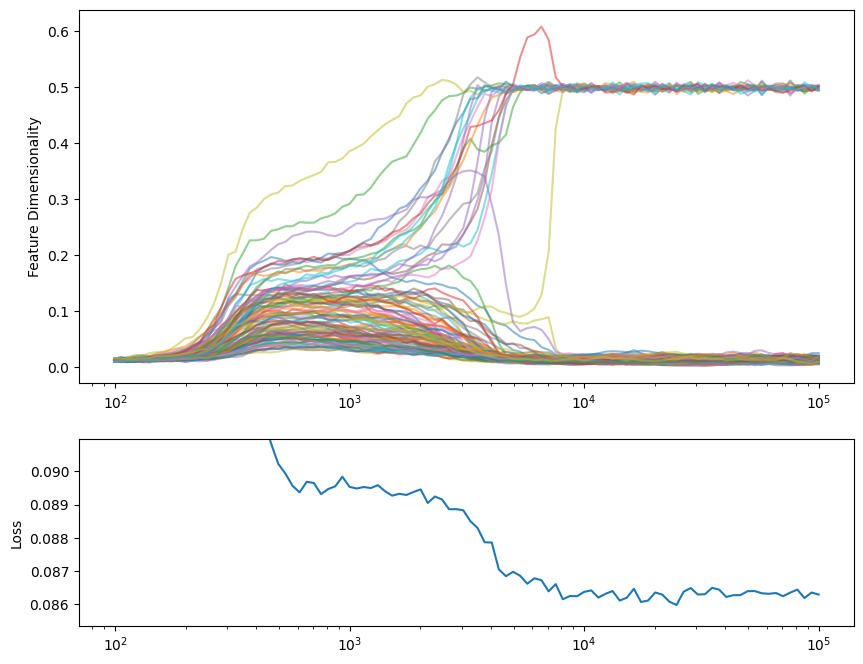

In [ ]:
plot_dimensionality_over_time(dimensionalities, losses, test_iters)

We train a model with two sets of three correlated features with three hidden dimensions. We then plot the feature geometry in 3D, which can optionally be done in an interactive mode, allowing you to rotate and zoom the plot.

In [ ]:
config = {
    'n_feat_sets': 2,
    'features_per_set': 3,
    'hidden_dim': 3,
    'n_instances': 1,
    'S': torch.tensor([0.99]),
}
config['I'] = torch.ones((config['n_feat_sets'] * config['features_per_set']))
net = ReLUOutputCorrelated(**config)

# Reducing intialization scale to get cleaner plots
net.W = nn.Parameter(net.W.detach().clone() * 0.1)

# Store weights+loss at 100 points between iterations 0 to 100,000 (log-scale spacing)
n_iters = 100
start_exp, end_exp = 0, 4
test_iters = (torch.logspace(start_exp, end_exp, n_iters).int() - 1).unique()

weights, losses = train_with_checkpoints(net, test_iters, test_batch_size=10_000,
                                         batch_size=256, lr=5e-3, lr_scheduler="constant")
weights = torch.stack([weight['W'][0] for weight in weights])
losses = torch.tensor([loss[0].item() for loss in losses])

100%|██████████| 10000/10000 [00:35<00:00, 282.31it/s]


In [ ]:
# To enable an interactive version of the 3D plot, extra setup needs to be done.
interactive = False
if interactive:
    !pip install ipympl
    from google.colab import output
    # Enables widgets outside of the ipywidgets package
    output.enable_custom_widget_manager()

# When you're done, you may want to run
# output.disable_custom_widget_manager()

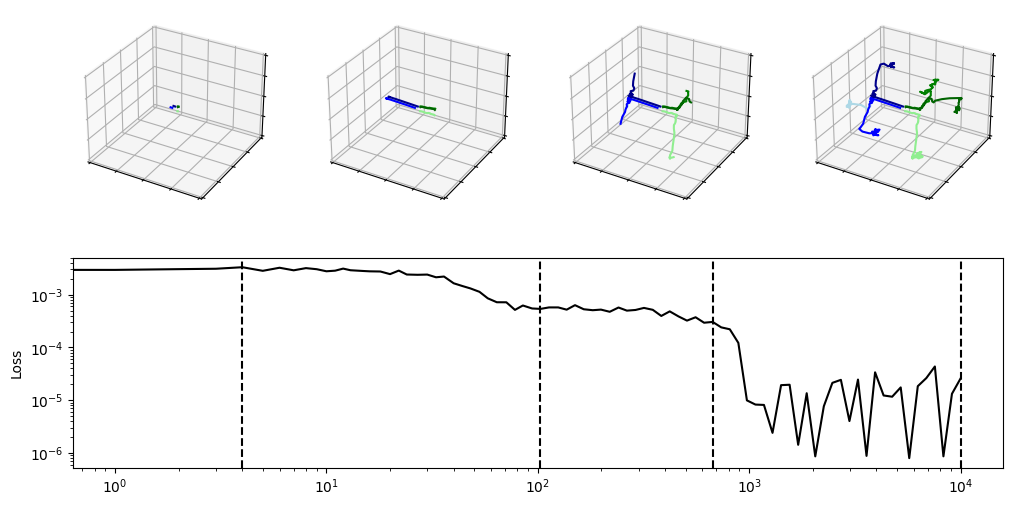

In [ ]:
if interactive:
    %matplotlib widget

plt.close()

# iteration_limits index into test_iters, only showing model weights prior to that iteration
iteration_limits = [5, 35, 55, len(test_iters)]
plot_3D_geometry(weights, test_iters, iteration_limits, figure=None)

plt.show()

if interactive:
    # Turn off interaction
    %matplotlib inline

## Relationship to Adversarial Robustness

#### Plotting Code

In [ ]:
def get_adversarial_loss(model):
    W = model.W.detach().clone()

    # Calculate W W^T
    W_WT = torch.einsum('...ij,...kj->...ik', W, W)

    # Find the worst adversarial attack for each instance over all features
    worst_adv_loss = torch.zeros(config['n_instances'])
    for i in range(config['n_feat']):
        # Normalize and multiply by 0.1 so norm of attack is at most 0.1
        adv_example = 0.1 * (W_WT[:, :, i] / torch.norm(W_WT[:, :, i], dim=1).unsqueeze(-1))
        # Calculate loss on adversarial example
        x = model(adv_example.unsqueeze(0))
        adv_loss = net.loss_fn(W_WT[:, :, i].unsqueeze(0), x, model.I).detach()
        worst_adv_loss = torch.maximum(worst_adv_loss, adv_loss)

    return worst_adv_loss

def get_adversarial_vulnerability(baseline_net, superpos_net):
    # Get adversarial loss of baseline and superposition model
    baseline_adv_loss = get_adversarial_loss(baseline_net)
    adv_loss = get_adversarial_loss(superpos_net)
    # Get test loss of both models
    x = baseline_net.get_batch(100_000)
    baseline_loss = net.loss_fn(x, baseline_net(x), baseline_net.I).detach()
    loss = net.loss_fn(x, superpos_net(x), superpos_net.I).detach()
    return (adv_loss - loss) / (baseline_adv_loss - baseline_loss)

In [ ]:
def plot_adversarial_and_dimensionality(adversarial_vulnerability, features_per_dimension, figure=None):
    if figure is None:
        figure = plt.subplots(2, 1, figsize=(8, 6))
    fig, axes = figure

    # Plot adversarial vulnerability
    axes[0].plot(1 / (1 - config['S']), adversarial_vulnerability, color="black")
    axes[0].set_xscale("log")
    axes[0].set_ylabel("Adversarial Vulnerability")

    # Plot features per dimension
    axes[1].plot(1 / (1 - config['S']), features_per_dimension, color="black")
    axes[1].set_xscale("log")
    axes[1].set_xlabel("$1 / (1 - S)$ (log scale)")
    axes[1].set_ylabel("Features per Dimension")

def plot_adversarial_vs_dimensionality(adversarial_vulnerability, features_per_dimension, figure=None):
    if figure is None:
        figure = plt.subplots(1, 1, figsize=(4, 4))
    fig, ax = figure

    ax.plot(features_per_dimension, adversarial_vulnerability, color="black")
    ax.scatter(features_per_dimension, adversarial_vulnerability, color="black")
    ax.set_xlabel("Features per Dimension")
    ax.set_ylabel("Adversarial Vulnerability")

    ax.set_box_aspect(1)

#### Results

We train a set of linear models and ReLU-output models, and then create adversarial attacks as described in TMS.

To be concrete (since it is not written out in the paper), we plot the vulnerability to adversarial examples relative to a non-superposition model as:

$$
\begin{aligned}
\frac{\text{ReLU-Output Adversarial Loss} - \text{ReLU-Output Test Loss}}{\text{Linear Adversarial Loss} - \text{Linear Test Loss}}
\end{aligned}
$$

In [ ]:
config = {
    'n_feat': 20,
    'hidden_dim': 5,
    'n_instances': 40
}
config['S'] = 1 - 1 / torch.linspace(1, 10, config['n_instances'])
config['I'] = torch.pow(0.9, torch.arange(config['n_feat']))

trials = 5
linear_net = LinearModel(**config)
_ = train_trials(linear_net, trials, iterations=10_000, lr=1e-3, lr_scheduler="constant")

trials = 5
net = ReLUOutput(**config)
_ = train_trials(net, trials, iterations=10_000, lr=1e-3, lr_scheduler="constant")

100%|██████████| 5/5 [02:18<00:00, 27.70s/it]


In [ ]:
# Calculate vulnerability to adversarial examples (relative to a linear model)
adversarial_vulnerability = get_adversarial_vulnerability(linear_net, net)
# Calculate the average number of features per hidden dimension
features_per_dimension = [(torch.norm(net.W[i].detach(), p='fro')**2 / net.hidden_dim)
                          for i in range(config['n_instances'])]

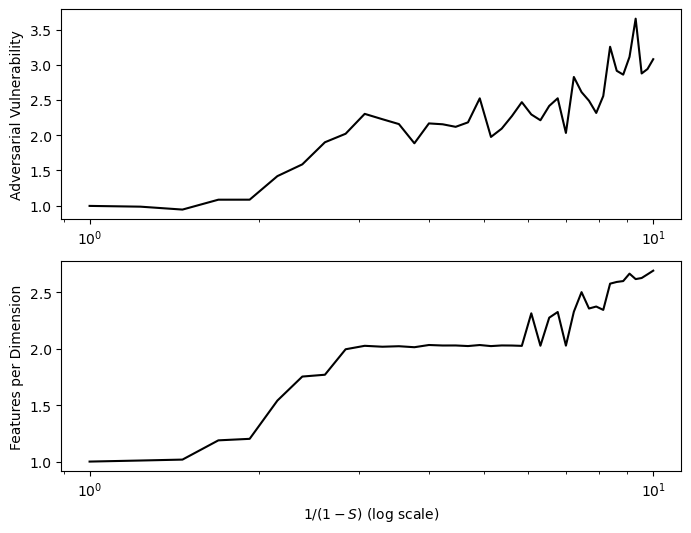

In [ ]:
plot_adversarial_and_dimensionality(adversarial_vulnerability, features_per_dimension)

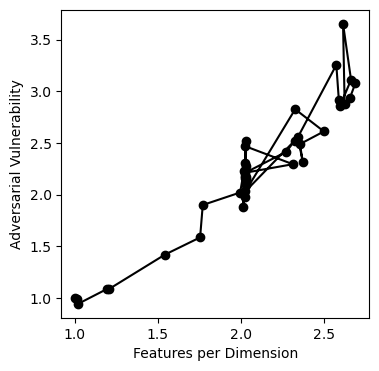

In [ ]:
plot_adversarial_vs_dimensionality(adversarial_vulnerability, features_per_dimension)

## Superposition in a Priviledged Basis

#### Model Code

In [ ]:
class ReLUHidden(ReLUOutput):
    def forward(self, x):
        # x: (batch, n_instances, n_feat)
        h = f.relu(torch.einsum('...if,...ifh->...ih', x, self.W))
        return f.relu(torch.einsum('...ih,...ifh->...if', h, self.W) + self.b)

#### Plotting Code

In [ ]:
def plot_matrix_row(Ws, figure=None, titles=None, colorbar=False):
    if figure is None:
        figure = plt.subplots(1, len(Ws), figsize=(10, 5))
    fig, axes = figure

    for i in range(len(Ws)):
        plot_matrix(Ws[i], figure=(fig, axes[i]))
        remove_all_labels(axes[i])
        if titles is not None:
            axes[i].set_title(titles[i])
        if colorbar:
            fig.colorbar(axes[i].get_images()[0], ax=axes[i])

#### Results

We plot $W$ for the ReLU-Output and ReLU-Hidden models at a few different sparsities.

In [ ]:
config = {
    'n_feat': 10,
    'hidden_dim': 5,
    'S': torch.tensor([0, 0.7, 0.9]),
}
config['n_instances'] = len(config['S'])
config['I'] = torch.pow(0.7, torch.arange(config['n_feat']))

linear_hidden_net = ReLUOutput(**config)
losses = train_weighted(linear_hidden_net, iterations=5_000, lr=0.05)

relu_hidden_net = ReLUHidden(**config)
losses = train_weighted(relu_hidden_net, iterations=5_000, lr=0.05)

Loss: 0.00000232: 100%|██████████| 5000/5000 [00:29<00:00, 166.72it/s]


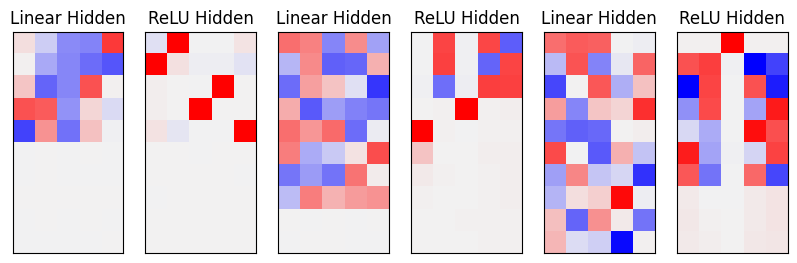

In [ ]:
# Interleave linear and relu hidden instances
linear_hidden_weights = [linear_hidden_net.W[i].detach() for i in range(config['n_instances'])]
relu_hidden_weights = [relu_hidden_net.W[i].detach() for i in range(config['n_instances'])]
weights = [W for Ws in zip(linear_hidden_weights, relu_hidden_weights) for W in Ws]

titles = ["Linear Hidden", "ReLU Hidden"] * config['n_instances']
plot_matrix_row(weights, titles=titles)

We plot $W$ as well as a "stacked neuron bar plot" for ReLU-Hidden models across a range of sparsities. Features are colored by their superposition.

In [ ]:
config = {
    'n_feat': 10,
    'hidden_dim': 5,
    'S': torch.tensor([0.0, 0.65, 0.85, 0.88, 0.94, 0.99]),
}
config['n_instances'] = len(config['S'])
config['I'] = torch.pow(0.7, torch.arange(config['n_feat']))

net = ReLUHidden(**config)
losses = train_weighted(net, iterations=10_000)

Loss: 0.00000155: 100%|██████████| 10000/10000 [01:11<00:00, 139.41it/s]


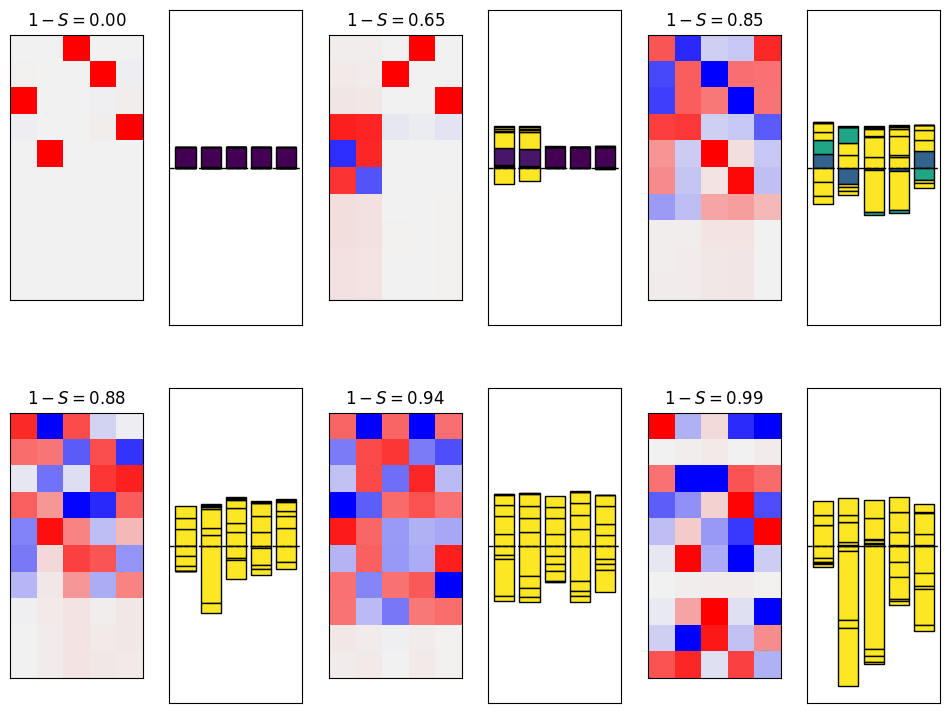

In [ ]:
fig, axes = plt.subplots(2, 6, figsize=(12, 9))

for i in range(config['n_instances']):
    row = i // (config['n_instances'] // 2)
    col = i % (config['n_instances'] // 2)

    plot_matrix(net.W[i].detach(), (fig, axes[row, 2*col]))
    remove_all_labels(axes[row, 2*col])
    axes[row, 2*col].set_title(f'$1-S={config["S"][i]:.2f}$')

    stacked_neuron_bar_plot(fig, axes[row, 2*col+1], net.W[i].detach())
    remove_all_labels(axes[row, 2*col+1])

## Computation in Superposition

#### Model Code

We define a new model architecture and task for the absolute value problem in this section.

In [ ]:
class UntiedReLUHidden(ReLUOutput):
    def reset_weights(self):
        self.W1 = nn.Parameter(torch.zeros(self.n_instances, self.n_feat, self.hidden_dim))
        self.W1 = nn.init.xavier_normal_(self.W1)

        self.W2 = nn.Parameter(torch.zeros(self.n_instances, self.n_feat, self.hidden_dim))
        self.W2 = nn.init.xavier_normal_(self.W2)
        self.b = nn.Parameter(torch.zeros(self.n_instances, self.n_feat))

    def forward(self, x):
        # x: (batch, n_instances, n_feat)
        h = f.relu(torch.einsum('...if,...ifh->...ih', x, self.W1))
        return f.relu(torch.einsum('...ih,...ifh->...if', h, self.W2) + self.b)

    def get_weights(self):
        return {'W1': self.W1, 'W2': self.W2, 'b': self.b}

    def set_weights(self, W1, W2, b):
        self.W1.data = W1.data
        self.W2.data = W2.data
        self.b.data = b.data

    def get_batch(self, batch_size):
        return (
            torch.bernoulli(torch.ones((batch_size, config['n_instances'], config['n_feat'])) - self.S_exp) *
            (2 * torch.rand((batch_size, config['n_instances'], config['n_feat'])) - 1)
        )

    def loss_fn(self, inputs, outputs, I):
        # Same as the standard importance-weight loss, but for the absolute value of inputs
        return torch.mean(I * torch.square(torch.abs(inputs) - outputs), dim=(0, 2))

#### Results

We plot a stacked neuron bar plot for $W1$ and $W2$ when trained without sparsity. Note that here bars are colored according to their feature, rather than the amount of superposition.

In [ ]:
config = {
    'n_feat': 3,
    'hidden_dim': 6,
    'n_instances': 1
}
config['S'] = torch.tensor([0])
config['I'] = torch.pow(0.7, torch.arange(config['n_feat']))
net = UntiedReLUHidden(**config)

losses = train_weighted(net, iterations=2_000)

Loss: 0.00000000: 100%|██████████| 2000/2000 [00:11<00:00, 180.54it/s]


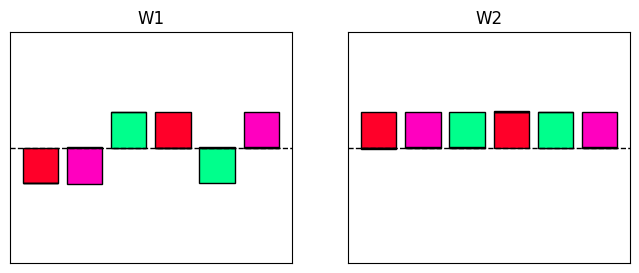

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

stacked_neuron_bar_plot(fig, axes[0], net.W1[0].detach(), normalize=True, color_by="feature", title=False)
remove_all_labels(axes[0])
axes[0].set_title("W1")
stacked_neuron_bar_plot(fig, axes[1], net.W2[0].detach(), normalize=True, color_by="feature", title=False)
remove_all_labels(axes[1])
axes[1].set_title("W2")
plt.show()

We then plot stacked neuron bar plots for larger models across a range of sparsities. Note we are back to coloring bars by the superposition of the corresponding feature.

Also note that the neurons are *not* sorted by the importance of their largest feature as in TMS. The bars for the models with the highest sparsity may be cut off in order to keep the scales consistent. Plotting may take about a minute.

In [ ]:
config = {
    'n_feat': 100,
    'hidden_dim': 40,
    'S': torch.tensor([0.0, 0.7, 0.9, 0.97, 0.99, 0.997, 0.999]),
}
config['n_instances'] = len(config['S'])
config['I'] = torch.pow(0.8, torch.arange(config['n_feat']))
net = UntiedReLUHidden(**config)

trials = 1
losses = train_weighted(net, iterations=2_000, batch_size=1024, weight_decay=0.1)

Loss: 0.00000000: 100%|██████████| 2000/2000 [01:30<00:00, 22.09it/s]


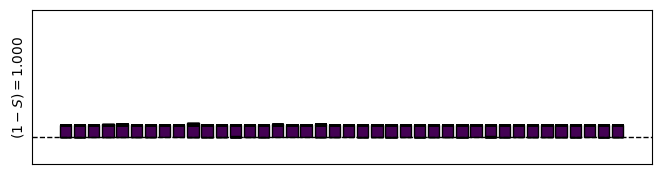

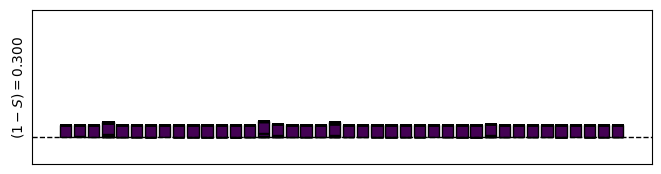

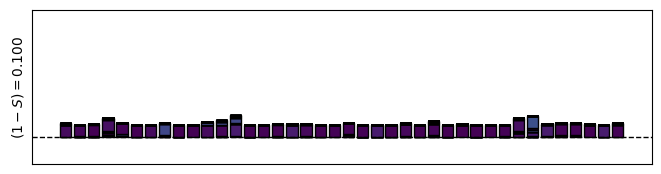

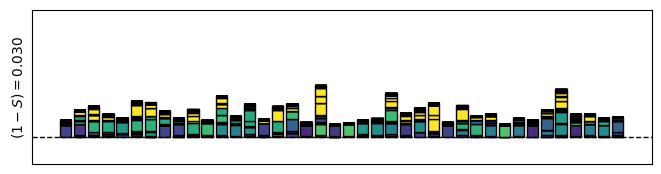

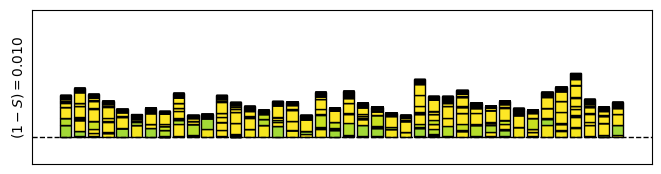

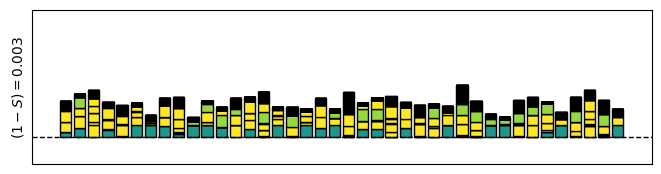

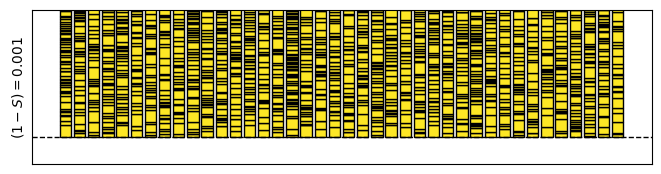

In [ ]:
for i in range(config['n_instances']):
    fig, ax = plt.subplots(1, 1, figsize=(8, 2))
    stacked_neuron_bar_plot(fig, ax, net.W1[i].detach(), normalize=True, abs_weight=True, color_by="super", title=False)
    remove_all_labels(ax)
    ax.set_ylabel(f"$(1-S)={1-config['S'][i]:.3f}$")
    plt.show()

Here we recreate the 'asymmetric superposition' motif as described in TMS. We've fixed a seed to ensure we see the motif when re-running the notebook.

In this fixed example (`seed = 5`), the red, yellow, and light blue features are implementing absolute value in the expected way, as well as the green feature in neuron 8 and the blue feature in neuron 10. You can see the asymmetric superposition with inhibition with the blue and pink features in neurons 1 and 5, and with the green and pink features in neurons 6 and 9.

In [ ]:
seed = 5

In [ ]:
config = {
    'n_feat': 6,
    'hidden_dim': 10,
    'n_instances': 1
}
config['S'] = torch.tensor([0.8])
config['I'] = torch.pow(0.7, torch.arange(config['n_feat']))

torch.manual_seed(seed)
net = UntiedReLUHidden(**config)

trials = 1
losses = train_weighted(net, iterations=5_000, batch_size=128, verbose=True)

Loss: 0.00000129: 100%|██████████| 5000/5000 [00:36<00:00, 136.03it/s]


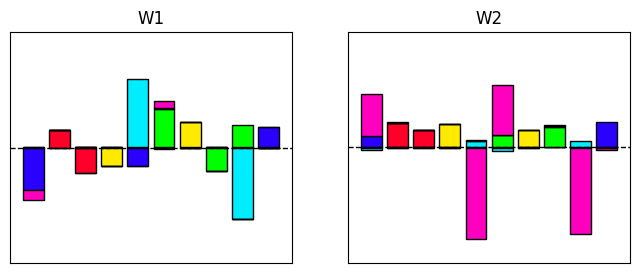

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

stacked_neuron_bar_plot(fig, axes[0], net.W1[0].detach(), normalize=False, color_by="feature", title=False)
remove_all_labels(axes[0])
axes[0].set_title("W1")
stacked_neuron_bar_plot(fig, axes[1], net.W2[0].detach(), normalize=False, color_by="feature", title=False)
remove_all_labels(axes[1])
axes[1].set_title("W2")
plt.show()

## Conclusion

Thanks for reading! If you have any questions or comments feel free to reach out.